## What is the most optimal skill for the given list of profession.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datasets import load_dataset

data = load_dataset("lukebarousse/data_jobs")
df = data['train'].to_pandas()

df.drop_duplicates()
df['job_posted_date'] = pd.to_datetime(df.job_posted_date)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785741 entries, 0 to 785740
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   job_title_short        785741 non-null  object        
 1   job_title              785740 non-null  object        
 2   job_location           784696 non-null  object        
 3   job_via                785733 non-null  object        
 4   job_schedule_type      773074 non-null  object        
 5   job_work_from_home     785741 non-null  bool          
 6   search_location        785741 non-null  object        
 7   job_posted_date        785741 non-null  datetime64[ns]
 8   job_no_degree_mention  785741 non-null  bool          
 9   job_health_insurance   785741 non-null  bool          
 10  job_country            785692 non-null  object        
 11  salary_rate            33067 non-null   object        
 12  salary_year_avg        22003 non-null   floa

In [2]:
df.job_title_short.unique()

array(['Senior Data Engineer', 'Data Analyst', 'Data Engineer',
       'Business Analyst', 'Data Scientist', 'Machine Learning Engineer',
       'Senior Data Analyst', 'Cloud Engineer', 'Senior Data Scientist',
       'Software Engineer'], dtype=object)

### Input :

In [3]:
lst = ['Data Scientist', 'Data Engineer', 'Data Analyst', 'Business Analyst']

### Output :

In [4]:
df_og = df.copy()

df.dropna(subset = ['job_title_short','job_skills','salary_year_avg'], inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20170 entries, 28 to 785692
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   job_title_short        20170 non-null  object        
 1   job_title              20170 non-null  object        
 2   job_location           19920 non-null  object        
 3   job_via                20170 non-null  object        
 4   job_schedule_type      20158 non-null  object        
 5   job_work_from_home     20170 non-null  bool          
 6   search_location        20170 non-null  object        
 7   job_posted_date        20170 non-null  datetime64[ns]
 8   job_no_degree_mention  20170 non-null  bool          
 9   job_health_insurance   20170 non-null  bool          
 10  job_country            20170 non-null  object        
 11  salary_rate            20170 non-null  object        
 12  salary_year_avg        20170 non-null  float64       
 13  sala

In [5]:
df_ex = df.copy()

import ast
df_ex['job_skills'] = df_ex.job_skills.apply(lambda sk : ast.literal_eval(sk) if pd.notna(sk) else sk)

In [6]:
df_ex = df_ex.explode('job_skills')

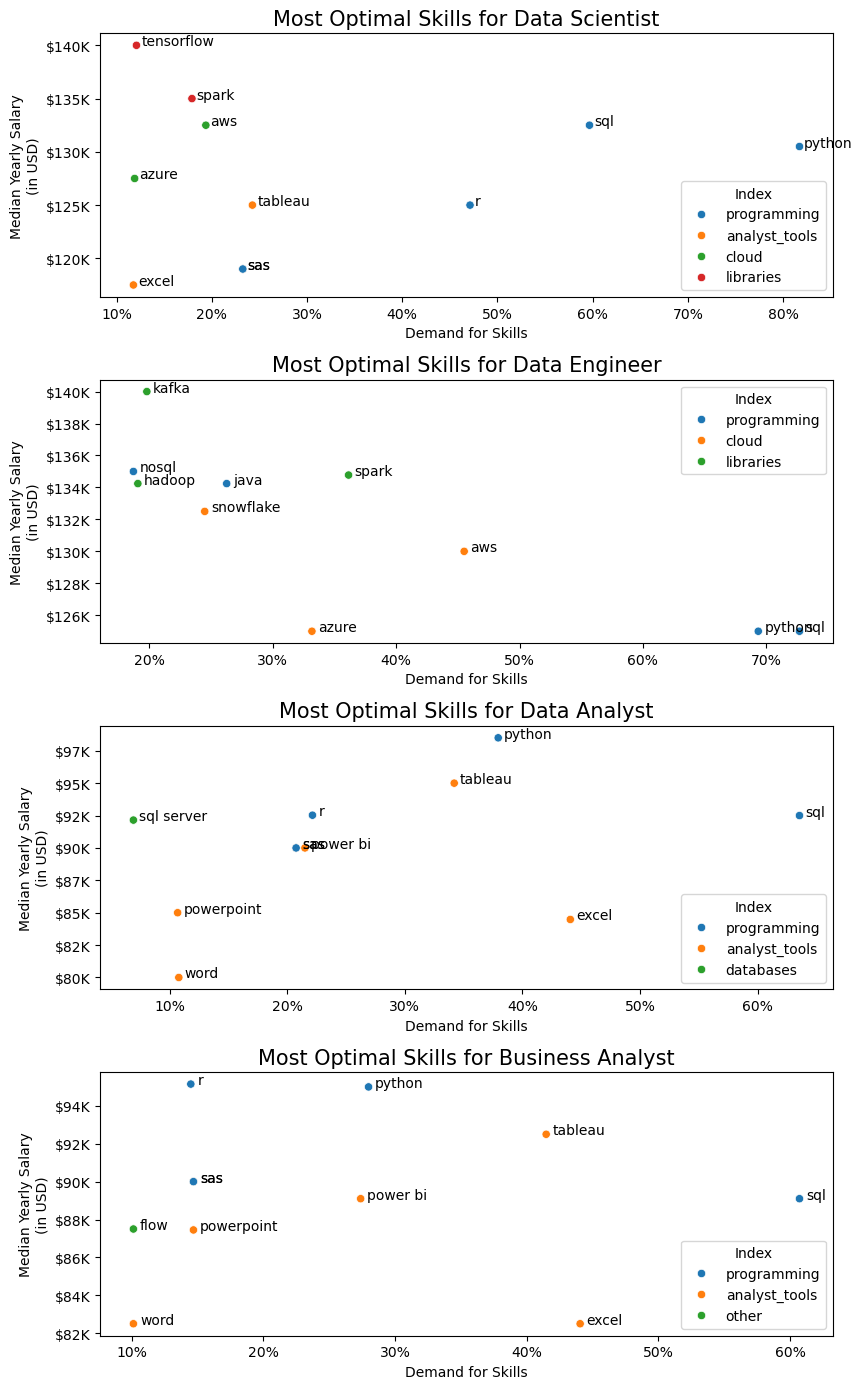

In [7]:
fig, ax = plt.subplots(len(lst), 1, figsize = (2.5*3.5,len(lst)*3.5))

for i,job in enumerate(lst) :
    dfs = df.copy()
    df_exs = df_ex.copy()

    dfs = dfs[dfs['job_title_short'] == job]
    df_exs = df_exs[df_exs['job_title_short'] == job]

    df_gb = (df_exs.groupby(by = 'job_skills')
            .aggregate(count = ('job_skills', 'size')
                    , median_sal = ('salary_year_avg', 'median'))
            .sort_values(by = 'count', ascending = False)
    )
    df_gb['demand'] = (df_gb['count']/len(dfs.job_title_short))*100
    df_gb['demand'] = df_gb.demand.apply(lambda d : round(d, 2))
    df_gb = df_gb[0:10]
    
    df_job_type = dfs['job_type_skills']

    dict_jt = {}
    for rw in df_job_type :
        dict_rw = ast.literal_eval(rw)

        for key,value in dict_rw.items() :
            if key in dict_jt :
                dict_jt[key] += value
            else :
                dict_jt[key] = value

    for key,value in dict_jt.items() :
        dict_jt[key] = list(set(value))

    df_jt = pd.DataFrame(dict_jt.items(), columns = ['job_types', 'job_skills'])

    df_jt_ex = df_jt.explode('job_skills')
    df_gb.reset_index(inplace = True)
    df_plt = df_gb.merge(df_jt_ex, how = 'left', on = 'job_skills')

    sns.scatterplot(data = df_plt, x = 'demand', y = 'median_sal', hue = 'job_types', ax = ax[i])
    ax[i].set_title(f'Most Optimal Skills for {job}', fontsize = 15)
    ax[i].set_ylabel('Median Yearly Salary\n(in USD)')
    ax[i].set_xlabel('Demand for Skills')
    ax[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos : f'${int(y/1000)}K'))
    if i == 1 :
        ax[i].legend(loc = 'upper right', title = 'Index')
    else :
        ax[i].legend(loc = 'lower right', title = 'Index')

    from matplotlib.ticker import PercentFormatter
    ax[i].xaxis.set_major_formatter(PercentFormatter(decimals = 0))

    for j,sk in enumerate(df_plt['job_skills']) :
        ax[i].text(x = (df_plt.demand.iloc[j] + 0.5), y = df_plt.median_sal.iloc[j], s = sk)

fig.tight_layout()